In [2]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Reshape,Flatten,Conv2D
import matplotlib.pyplot as plt 

In [3]:
import pickle 
import seaborn as sns 

In [4]:
model=VGG16(weights='imagenet',include_top=False,input_shape=(128,128,3))
model=Model(inputs=model.input,outputs=Flatten()(model.output))

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [6]:
for i in model.layers:
    i.trainable=False
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [7]:
var=model.output
Dense1=Dense(800,activation="sigmoid")(var)
Dense2=Dense(2,activation="softmax")(Dense1)

In [8]:
vgg=Model(inputs=model.input,outputs=Dense2)
vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [9]:
Xtrain=pickle.load(open('xtrain','rb'))
ytrain=pickle.load(open('ytrain','rb'))
xtest=pickle.load(open('xtest','rb'))
ytest=pickle.load(open('ytest','rb'))

In [10]:
print(Xtrain.shape,xtest.shape)

(9484, 128, 128, 3) (2372, 128, 128, 3)


In [11]:
from tensorflow.keras.utils import to_categorical as toc
ytrain_one=toc(ytrain)
ytest_one=toc(ytest)

In [15]:
vgg.compile(optimizer="Adam",loss="binary_crossentropy",metrics=["accuracy"])
vg=vgg.fit(Xtrain,ytrain_one,validation_data=(xtest,ytest_one),epochs=3,batch_size=30)

Epoch 1/3
317/317 [==============================] - 193s 588ms/step - loss: 0.2323 - accuracy: 0.8979 - val_loss: 0.1993 - val_accuracy: 0.9174
Epoch 2/3
317/317 [==============================] - 184s 581ms/step - loss: 0.1671 - accuracy: 0.9303 - val_loss: 0.1700 - val_accuracy: 0.9250
Epoch 3/3
317/317 [==============================] - 184s 582ms/step - loss: 0.1534 - accuracy: 0.9372 - val_loss: 0.1598 - val_accuracy: 0.9330


In [16]:
vgg.save("vgg_dense.h5")

In [17]:
import numpy as np
predict=vgg.predict(xtest)
predict=np.argmax(predict,axis=-1)
print(predict)

[1 1 1 ... 1 0 0]


<AxesSubplot:>

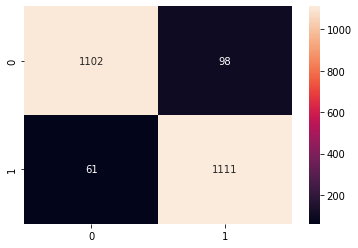

In [18]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ytest,predict)
sns.heatmap(cm,annot=True,fmt="g")

In [21]:
from sklearn.metrics import classification_report
print(classification_report(ytest,predict))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1200
           1       0.92      0.95      0.93      1172

    accuracy                           0.93      2372
   macro avg       0.93      0.93      0.93      2372
weighted avg       0.93      0.93      0.93      2372



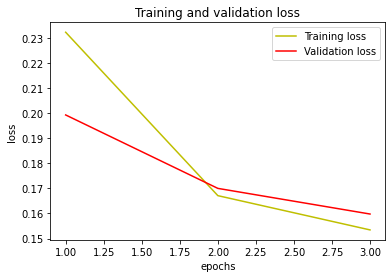

In [22]:
loss=vg.history['loss']
val_loss=vg.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

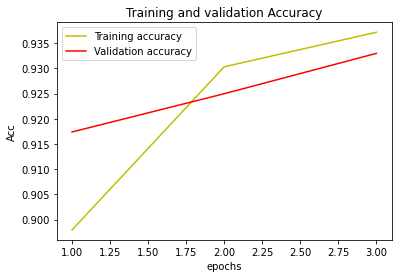

In [23]:
accuracy=vg.history['accuracy']
val_accuracy=vg.history['val_accuracy']
plt.plot(epochs,accuracy,'y',label='Training accuracy')
plt.plot(epochs,val_accuracy,'r',label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [24]:
model.save('vgg.h5')

In [25]:
from keras.models import load_model
from numpy.random import randn

m = load_model('vgg.h5') 

In [26]:
x_train_f=m.predict(Xtrain)
x_test_f=m.predict(xtest)

In [27]:
x_train_f[0].shape

(8192,)

In [28]:
from sklearn.ensemble import RandomForestClassifier
RFmodel = RandomForestClassifier(n_estimators=10, random_state=300)
RFmodel.fit(x_train_f,ytrain)

RandomForestClassifier(n_estimators=10, random_state=300)

In [29]:
predict_RF=RFmodel.predict(x_test_f)
from sklearn import metrics
print(metrics.accuracy_score(ytest,predict_RF))

0.9300168634064081


<AxesSubplot:>

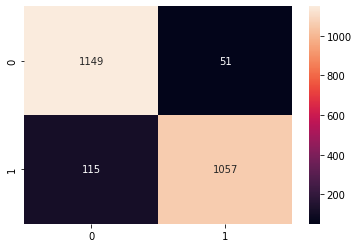

In [30]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ytest,predict_RF)
sns.heatmap(cm,annot=True,fmt="g")

In [32]:
from sklearn.metrics import classification_report
print(classification_report(ytest,predict_RF))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1200
           1       0.95      0.90      0.93      1172

    accuracy                           0.93      2372
   macro avg       0.93      0.93      0.93      2372
weighted avg       0.93      0.93      0.93      2372



In [33]:
r="vgg_rf.sav"

In [34]:
pickle.dump(RFmodel,open(r,'wb'))

In [35]:
v2=pickle.load(open("vgg_svm.sav",'rb'))
v2.predict(f)

NameError: name 'f' is not defined

In [36]:
from sklearn.svm import LinearSVC
svmodel=LinearSVC(max_iter=100)
svmodel.fit(x_train_f,ytrain)

C:\Users\sudhakararao\anaconda3\envs\tf2.4\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=100)

In [37]:
predict_svm=svmodel.predict(x_test_f)

In [38]:
from sklearn import metrics
print(metrics.accuracy_score(ytest,predict_svm))

0.9721753794266442


<AxesSubplot:>

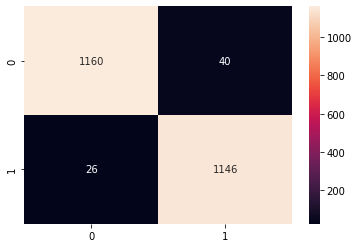

In [39]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ytest,predict_svm)
sns.heatmap(cm,annot=True,fmt="g")

In [40]:
from sklearn.metrics import classification_report
print(classification_report(ytest,predict_svm))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1200
           1       0.97      0.98      0.97      1172

    accuracy                           0.97      2372
   macro avg       0.97      0.97      0.97      2372
weighted avg       0.97      0.97      0.97      2372



In [41]:
v="vgg_svm.sav"

In [42]:
pickle.dump(svmodel,open(v,'wb'))

In [43]:
v1=pickle.load(open("vgg_svm.sav",'rb'))
v1.predict(f)

NameError: name 'f' is not defined

In [44]:
img=cv2.imread(r"C:\Users\sudhakararao\Desktop\Project\divideddataset\generated_negative_images\non_covid_100.jpg")
img=cv2.resize(img,(128,128))
plt.imshow(img)

NameError: name 'cv2' is not defined

In [45]:
f=m.predict(Xtrain[0:1])
print(f)

[[ 0.        0.        0.       ...  0.       16.980093  0.      ]]
